In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


In [2]:
np.random.seed(0)

N = 5000  # number of samples
i = np.random.uniform(0.1, 10, N)  # voltage (avoid zero)
true_G = np.random.choice([0.001, 0.01, 0.1, 1.0, 10.0], N)  # 5 discrete G values
v = i * true_G  # i = G * v



In [3]:
v

array([5.53325369e+00, 7.18037473e-02, 6.06735742e+00, ...,
       2.05414380e-03, 4.04700347e+00, 9.59007172e-02])

In [4]:
true_G

array([1.   , 0.01 , 1.   , ..., 0.001, 1.   , 0.01 ])

In [5]:
G_classes = {0.001: 0, 0.01: 1, 0.1: 2, 1.0: 3, 10.0: 4}
labels = np.array([G_classes[g] for g in true_G])

In [6]:
labels

array([3, 1, 3, ..., 0, 3, 1])

In [7]:
X = np.stack((v, i), axis=1)
y = labels

In [8]:
X


array([[5.53325369e+00, 5.53325369e+00],
       [7.18037473e-02, 7.18037473e+00],
       [6.06735742e+00, 6.06735742e+00],
       ...,
       [2.05414380e-03, 2.05414380e+00],
       [4.04700347e+00, 4.04700347e+00],
       [9.59007172e-02, 9.59007172e+00]])

In [9]:
y


array([3, 1, 3, ..., 0, 3, 1])

In [10]:
X,y

(array([[5.53325369e+00, 5.53325369e+00],
        [7.18037473e-02, 7.18037473e+00],
        [6.06735742e+00, 6.06735742e+00],
        ...,
        [2.05414380e-03, 2.05414380e+00],
        [4.04700347e+00, 4.04700347e+00],
        [9.59007172e-02, 9.59007172e+00]]),
 array([3, 1, 3, ..., 0, 3, 1]))

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
    

In [12]:

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)


In [13]:
X_train_t

tensor([[7.1783e+00, 7.1783e+00],
        [5.2045e+00, 5.2045e-01],
        [4.9593e-03, 4.9593e-01],
        ...,
        [6.6803e+00, 6.6803e+00],
        [1.7868e+01, 1.7868e+00],
        [9.3775e-02, 9.3775e+00]])

In [14]:
class GClassifier(nn.Module):
    def __init__(self):
        super(GClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 5)  # 5 classes
        )

    def forward(self, x):
        return self.model(x)


In [15]:

# Train model
model = GClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [16]:
# Training loop
epochs = 20
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {loss.item():.4f}")


Epoch [5/20] Loss: 3.4457
Epoch [10/20] Loss: 2.4925
Epoch [15/20] Loss: 1.7552
Epoch [20/20] Loss: 1.4289


In [17]:
# Predict
with torch.no_grad():
    y_pred_logits = model(X_test_t)
    y_pred = torch.argmax(y_pred_logits, dim=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred.numpy(), target_names=[f'Class {i}' for i in range(5)]))



Classification Report:
              precision    recall  f1-score   support

     Class 0       0.29      0.68      0.41       176
     Class 1       0.00      0.00      0.00       228
     Class 2       0.29      0.33      0.31       212
     Class 3       0.00      0.00      0.00       180
     Class 4       0.56      0.97      0.71       204

    accuracy                           0.39      1000
   macro avg       0.23      0.39      0.28      1000
weighted avg       0.23      0.39      0.28      1000



C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.

In [18]:
import collections
print("Label distribution:", collections.Counter(y))


Label distribution: Counter({2: 1039, 1: 1025, 0: 986, 3: 976, 4: 974})


In [19]:
from collections import Counter
print("Predicted class distribution:", Counter(y_pred.numpy()))


Predicted class distribution: Counter({0: 411, 4: 354, 2: 235})


Epoch 10/100 - Loss: 1.5492 - Acc: 0.3692
Epoch 20/100 - Loss: 1.4872 - Acc: 0.3733
Epoch 30/100 - Loss: 1.4176 - Acc: 0.4105
Epoch 40/100 - Loss: 1.3421 - Acc: 0.3932
Epoch 50/100 - Loss: 1.2744 - Acc: 0.3868
Epoch 60/100 - Loss: 1.2230 - Acc: 0.4195
Epoch 70/100 - Loss: 1.1849 - Acc: 0.4933
Epoch 80/100 - Loss: 1.1552 - Acc: 0.5425
Epoch 90/100 - Loss: 1.1303 - Acc: 0.5420
Epoch 100/100 - Loss: 1.1068 - Acc: 0.5462

Test Classification Report:
              precision    recall  f1-score   support

     Class 0       0.29      0.32      0.30       199
     Class 1       0.38      0.60      0.46       214
     Class 2       0.24      0.13      0.17       201
     Class 3       0.97      0.72      0.82       193
     Class 4       1.00      0.97      0.99       193

    accuracy                           0.55      1000
   macro avg       0.57      0.55      0.55      1000
weighted avg       0.57      0.55      0.54      1000

Predicted class distribution: Counter({1: 341, 0: 220, 4: 188

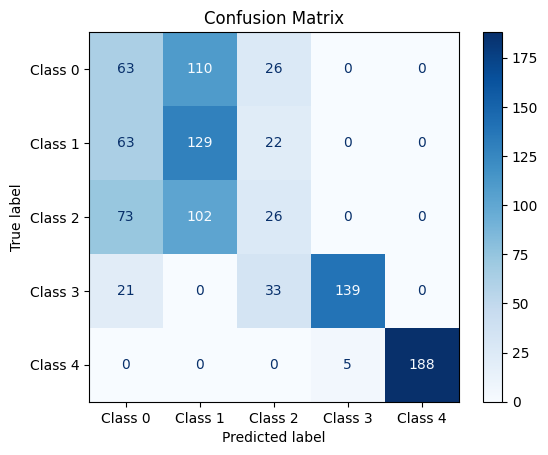

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

# Seed
np.random.seed(42)
torch.manual_seed(42)

# 1. Simulate data
N = 5000
G_levels = [0.001, 0.01, 0.1, 1.0, 10.0]
true_G = np.random.choice(G_levels, N, p=[0.2]*5)
i = np.random.uniform(0.1, 10, N)
v = i * true_G
G_classes = {g: i for i, g in enumerate(G_levels)}
labels = np.array([G_classes[g] for g in true_G])
X = np.stack((v, i), axis=1)

# 2. Normalize input
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.2, random_state=42)

# 4. Convert to torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

# 5. Define improved model
class GClassifier(nn.Module):
    def __init__(self):
        super(GClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 5)  # 5 classes
        )

    def forward(self, x):
        return self.model(x)

# 6. Train
model = GClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        _, preds = torch.max(outputs, 1)
        acc = (preds == y_train_t).float().mean()
        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f} - Acc: {acc:.4f}")

# 7. Evaluate
model.eval()
with torch.no_grad():
    y_pred_logits = model(X_test_t)
    y_pred = torch.argmax(y_pred_logits, dim=1)

print("\nTest Classification Report:")
print(classification_report(y_test, y_pred.numpy(), target_names=[f'Class {i}' for i in range(5)], zero_division=0))
print("Predicted class distribution:", Counter(y_pred.numpy()))

# 8. Confusion Matrix
cm = confusion_matrix(y_test, y_pred.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Class {i}' for i in range(5)])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [21]:
# Predict
with torch.no_grad():
    y_pred_logits = model(X_test_t)
    y_pred = torch.argmax(y_pred_logits, dim=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred.numpy(), target_names=[f'Class {i}' for i in range(5)]))



Classification Report:
              precision    recall  f1-score   support

     Class 0       0.29      0.32      0.30       199
     Class 1       0.38      0.60      0.46       214
     Class 2       0.24      0.13      0.17       201
     Class 3       0.97      0.72      0.82       193
     Class 4       1.00      0.97      0.99       193

    accuracy                           0.55      1000
   macro avg       0.57      0.55      0.55      1000
weighted avg       0.57      0.55      0.54      1000



In [22]:
np.savetxt("predicted_classes.csv", y_pred.numpy(), delimiter=",", fmt='%d')


In [23]:
# [v, i, class]
combined = np.concatenate([X_test, y_pred.numpy().reshape(-1, 1)], axis=1)
np.savetxt("G_classifier_lookup.csv", combined, delimiter=",", header="v,i,class", comments="")
